In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib_venn import venn2
from collections import Counter
from collections import defaultdict
import time

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import gensim
from keras.preprocessing import text
from keras.preprocessing import sequence
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import itertools
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import io
import json
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F

Using TensorFlow backend.


In [2]:
base_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch'
abstract_df=pd.read_csv(os.path.join(base_dir, 'data/abstract_citation_df_50930.csv'),index_col='pmid')
cancertype_flattened_df=pickle.load(open(os.path.join(base_dir, "data/cancertype_df2.pkl"),"rb"))

In [69]:
print('unique pmid with cancer types: {}'.format(cancertype_flattened_df.pmid.nunique()))
print('unique cancer types: {}'.format(cancertype_flattened_df.cancer_type.nunique()))

unique pmid with cancer types: 42455
unique cancer types: 55


In [70]:
cancertype_array=cancertype_flattened_df.cancer_type.unique()
print(len(cancertype_array))

55


In [71]:
abstract_train_df=abstract_df.loc[cancertype_flattened_df.pmid.unique(),:]
abstract_train_df.shape

(42455, 8)

In [72]:
abstract_test_df=abstract_df.loc[np.setdiff1d(abstract_df.index, cancertype_flattened_df.pmid.unique()),:]
abstract_test_df.shape

(8475, 8)

In [6]:
#stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
#stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
cancertype_words = ['adrenocortical', 'anal', 'appendix', 'bladder', 'bone', 'breast', 'cervical', 'gallbladder', 'ovarian', 'penile', 'prostate', 'rectal', 'skin', 'thyroid', 'vaginal', 'vulvar', 'urethral', 'parathyroid',
                    'carcinoid', 'pituitary', 'wilms', 'rhabdoid', 'melanoma', 'mesothelioma', 'neuroblastoma', 'osteosarcoma', 'pheochromocytoma', 'retinoblastoma', 'rhabdomyosarcoma', 'sarcoma',
                    'bile', 'colorectal', 'colon', 'cardiac', 'heart', 'endometrial', 'uterine', 'endometrium', 'uterus', 'esophageal', 'esophagus', 'ewing', 'sarcoma', 'fallopian', 'gastric', 'stomach', 'gastrointestinal',
                    'esthesioneuroblastoma', 'hypopharyngeal', 'laryngeal', 'nasopharyngeal', 'pharyngeal', 'salivary', 'oropharyngeal', 'neck', 'kidney', 'renal', 'leukemia', 'liver', 'hepatocellular', 'hepatocyte', 'hepatoblastoma',
                    'lung', 'bronchial', 'pleuropulmonar', 'tracheobronchial', 'non-small', 'lymphoma', 'non-hodgkin', 'hodgkin', 'burkitt', 'myeloma', 'myeloproliferative', 'myelodysplastic', 'pancreatic', 'pancreas', 'testicular', 'testicle', 'testicles', 'testis',
                    'Lung', 'Breast', 'Colon', 'Kidney', 'Leukemia', 'Lymphoma', 'brain', 'Brain']
#stop_words = set(list(stop_word1)+stop_word2+list(punct)+custom_words+cancertype_words)   ## 572
stop_words = set(list(punct)+cancertype_words)   ## 143

In [7]:
print(len(stop_words))

145


In [8]:
def preprocess(text):
    result=[]
    for sent in sent_tokenize(text):
        for token in word_tokenize(sent):
            if token.lower() not in stop_words:
                result.append(token)
    return " ".join(result)

In [9]:
abstract_train_df['abstract_clean'] = abstract_train_df.abstract.apply(lambda x:preprocess(x))
abstract_test_df['abstract_clean'] = abstract_test_df.abstract.apply(lambda x:preprocess(x))

In [64]:
cancertype_flattened_df.cancer_type.value_counts()

Breast Cancer                         7757
Lung Cancer                           5201
Leukemia                              4755
Prostate Cancer                       3878
Colorectal Cancer                     3412
Lymphoma                              2939
Bone Cancer                           2788
Melanoma                              2459
Liver Cancer                          2422
Kidney Cancer                         2262
Ovarian Cancer                        2216
Pancreatic Cancer                     1992
Brain Tumor                           1956
Head and Neck Cancer                  1914
Acute Myeloid Leukemia (AML)          1488
Multiple Myeloma                      1413
Sarcoma                               1407
Bladder Cancer                        1013
Skin Cancer                           1008
Gastric Cancer                         996
Gastrointestinal Tumor                 989
Endometrial Cancer                     962
Acute Lymphoblastic Leukemia (ALL)     903
Chronic Lym

In [27]:
cancer_types= np.array(cancertype_flattened_df.cancer_type.value_counts().index)[:29]

In [28]:
print(len(cancer_types))

29


In [78]:
abstract_train_df['pmid']=abstract_train_df.index
for i in cancer_types:
    cancer_pmid=cancertype_flattened_df[cancertype_flattened_df.cancer_type==i].pmid.unique()
    print('{} pmid for {}'.format(len(cancer_pmid), i))
    abstract_train_df[i]=abstract_train_df.pmid.apply(lambda x: 1 if x in cancer_pmid else 0)

7757 pmid for Breast Cancer
5201 pmid for Lung Cancer
4755 pmid for Leukemia
3878 pmid for Prostate Cancer
3412 pmid for Colorectal Cancer
2939 pmid for Lymphoma
2788 pmid for Bone Cancer
2459 pmid for Melanoma
2422 pmid for Liver Cancer
2262 pmid for Kidney Cancer
2216 pmid for Ovarian Cancer
1992 pmid for Pancreatic Cancer
1956 pmid for Brain Tumor
1914 pmid for Head and Neck Cancer
1488 pmid for Acute Myeloid Leukemia (AML)
1413 pmid for Multiple Myeloma
1407 pmid for Sarcoma
1013 pmid for Bladder Cancer
1008 pmid for Skin Cancer
996 pmid for Gastric Cancer
989 pmid for Gastrointestinal Tumor
962 pmid for Endometrial Cancer
903 pmid for Acute Lymphoblastic Leukemia (ALL)
803 pmid for Chronic Lymphocytic Leukemia (CLL)
797 pmid for Cardiac Tumors
788 pmid for Cervical Cancer
745 pmid for Esophageal Cancer
687 pmid for Thyroid Cancer
655 pmid for Rectal Cancer


In [79]:
abstract_train_df['Breast Cancer'].value_counts()

0    34698
1     7757
Name: Breast Cancer, dtype: int64

In [80]:
abstract_train_df.shape

(42455, 38)

### Vectorize corpus of text

In [12]:
## generate vocabulary based on a list of texts.
tokenizer=text.Tokenizer()
tokenizer.fit_on_texts(list(abstract_train_df.abstract_clean)+list(abstract_test_df.abstract_clean))

In [15]:
print('Total number of documents: {}'.format(tokenizer.document_count))
print('Size of the vocabulary: {}'.format(len(tokenizer.word_index.keys())))
print("Here are examples of 'tokenizer.word_index':")
print(list(tokenizer.word_index.keys())[:10])
print(list(tokenizer.word_index.values())[:10])

Total number of documents: 50930
Size of the vocabulary: 80064
Here are examples of 'tokenizer.word_index':
['of', 'and', 'the', 'in', 'with', 'to', 'patients', 'a', 'for', 'was']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [16]:
## Transforms each text in texts to a sequence of integers.
abstract_train_df['text_clean_seq']=tokenizer.texts_to_sequences(abstract_train_df.abstract_clean)
abstract_test_df['text_clean_seq']=tokenizer.texts_to_sequences(abstract_test_df.abstract_clean)

### Build embedding matrix

In [17]:
CRAWL_EMBEDDING_PATH = '/Volumes/Yuchen_Drive/Toxic_Comment/crawl-300d-2M.vec'
GLOVE_EMBEDDING_PATH = '/Volumes/Yuchen_Drive/Toxic_Comment/glove.840B.300d.txt'

In [18]:
def get_coefs(word, *arr):
    """
    Credit goes to https://www.kaggle.com/bminixhofer/simple-lstm-pytorch-version
    """
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    """
    Credit goes to https://www.kaggle.com/bminixhofer/simple-lstm-pytorch-version
    """
    with open(path) as f:
        return dict([get_coefs(*line.strip().split(' ')) for line in tqdm(f)])

In [19]:
def build_matrix(word_index, path):
    """
    Credit goes to https://www.kaggle.com/bminixhofer/simple-lstm-pytorch-version
    """
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index)+1, 300))
    unknown_words = []
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

In [20]:
crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, CRAWL_EMBEDDING_PATH)
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print("Number of total features: {}".format(len(tokenizer.word_index)))
print('Number of unknown words (crawl): {}'.format(len(unknown_words_crawl)))
print('Number of unknown words (glove): {}'.format(len(unknown_words_glove)))


Number of total features: 80064
Number of unknown words (crawl): 34158
Number of unknown words (glove): 35005


In [21]:
embedding_matrix = np.concatenate([crawl_matrix, glove_matrix], axis = 1)
print("crawl_matrix: {}".format(crawl_matrix.shape))
print("glove_matrix: {}".format(glove_matrix.shape))
print("embedding_matrix: {}".format(embedding_matrix.shape))

crawl_matrix: (80065, 300)
glove_matrix: (80065, 300)
embedding_matrix: (80065, 600)


In [78]:
pickle.dump(embedding_matrix, open(os.path.join(base_dir, "data/embedding_matrix2.pkl"), "wb"))

In [22]:
del crawl_matrix
del glove_matrix

### Split annotated datasets to training and validation sets based on specific cancer_type

In [5]:
cancer_prefix_dict={'Breast Cancer':'Doctor_recommendation_RNN4_breast_epoch100_lr5_gpu',
                   'Lung Cancer':'Doctor_recommendation_RNN4_lung_epoch100_lr5_gpu',
                   'Leukemia':'Doctor_recommendation_RNN4_leukemia_epoch100_lr5_gpu',
                   'Prostate Cancer':'Doctor_recommendation_RNN4_prostate_epoch100_lr5_gpu',
                   'Colorectal Cancer':'Doctor_recommendation_RNN4_colorectal_epoch100_lr5_gpu',
                   'Lymphoma':'Doctor_recommendation_RNN4_lymphoma_epoch100_lr5_gpu',
                   'Bone Cancer':'Doctor_recommendation_RNN4_bone_epoch100_lr5_gpu',
                   'Melanoma':'Doctor_recommendation_RNN4_melanoma_epoch100_lr5_gpu',
                   'Liver Cancer':'Doctor_recommendation_RNN4_liver_epoch100_lr5_gpu',
                   'Kidney Cancer':'Doctor_recommendation_RNN4_kidney_epoch100_lr5_gpu',
                   'Ovarian Cancer':'Doctor_recommendation_RNN4_ovarian_epoch100_lr5_gpu',
                   'Pancreatic Cancer':'Doctor_recommendation_RNN4_pancreatic_epoch100_lr5_gpu',
                   'Brain Tumor':'Doctor_recommendation_RNN4_brain_epoch100_lr5_gpu',
                   'Head and Neck Cancer':'Doctor_recommendation_RNN4_head_and_neck_epoch100_lr5_gpu',
                   'Acute Myeloid Leukemia (AML)':'Doctor_recommendation_RNN4_aml_epoch100_lr5_gpu',
                   'Multiple Myeloma':'Doctor_recommendation_RNN4_multiple_myeloma_epoch100_lr5_gpu',
                   'Sarcoma':'Doctor_recommendation_RNN4_sarcoma_epoch100_lr5_gpu',
                   'Bladder Cancer':'Doctor_recommendation_RNN4_bladder_epoch100_lr5_gpu',
                   'Skin Cancer':'Doctor_recommendation_RNN4_skin_epoch100_lr5_gpu',
                   'Gastric Cancer':'Doctor_recommendation_RNN4_gastric_epoch100_lr5_gpu',
                   'Gastrointestinal Tumor':'Doctor_recommendation_RNN4_gastrointestinal_epoch100_lr5_gpu',
                   'Endometrial Cancer':'Doctor_recommendation_RNN4_endometrial_epoch100_lr5_gpu',
                   'Acute Lymphoblastic Leukemia (ALL)':'Doctor_recommendation_RNN4_all_epoch100_lr5_gpu',
                   'Chronic Lymphocytic Leukemia (CLL)':'Doctor_recommendation_RNN4_cll_epoch100_lr5_gpu',
                   'Cardiac Tumors':'Doctor_recommendation_RNN4_cardiac_epoch100_lr5_gpu',
                   'Cervical Cancer':'Doctor_recommendation_RNN4_cervical_epoch100_lr5_gpu',
                   'Esophageal Cancer':'Doctor_recommendation_RNN4_esophageal_epoch100_lr5_gpu',
                   'Thyroid Cancer':'Doctor_recommendation_RNN4_thyroid_epoch100_lr5_gpu',
                   'Rectal Cancer':'Doctor_recommendation_RNN4_rectal_epoch100_lr5_gpu'
                   }


In [6]:
cancer_type='Breast Cancer'
prefix=cancer_prefix_dict[cancer_type]

In [75]:
abstract_train_df.shape

(42455, 8)

In [83]:
train_set,val_set=train_test_split(abstract_train_df,train_size=0.8,stratify=abstract_train_df[cancer_type],random_state=8)
val_set,test_set=train_test_split(val_set,train_size=0.5,stratify=val_set[cancer_type],random_state=8)
print('Number of samples in training set: {}'.format(train_set.shape[0]))
print('Number of samples in validation set: {}'.format(val_set.shape[0]))
print('Number of samples in testing set: {}'.format(test_set.shape[0]))
print('Number of samples in testing dataset: {}'.format(abstract_test_df.shape[0]))

Number of samples in training set: 33964
Number of samples in validation set: 4245
Number of samples in testing set: 4246
Number of samples in testing dataset: 8475


In [84]:
abstract_train_df['text_length']=abstract_train_df['abstract_clean'].apply(lambda x:len(x))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Density')

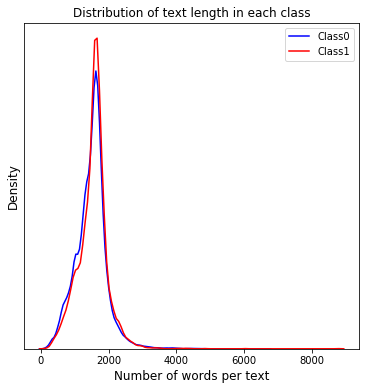

In [85]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
palette=['blue','red']
for i in range(2):
    sns.distplot(abstract_train_df[abstract_train_df[cancer_type]==i].text_length,color=palette[i],hist=False,ax=ax,label='Class{}'.format(i))
ax.set_title('Distribution of text length in each class',fontsize=12)
ax.set_xlabel('Number of words per text', fontsize=12)
ax.set_yticks([])
ax.set_ylabel('Density',fontsize=12)

### Padding sequence

In [86]:
## Pads sequences to the same length.
MAX_LEN=2000
train_x=sequence.pad_sequences(train_set.text_clean_seq,maxlen=MAX_LEN)
val_x=sequence.pad_sequences(val_set.text_clean_seq,maxlen=MAX_LEN)
test_x=sequence.pad_sequences(abstract_test_df.text_clean_seq,maxlen=MAX_LEN)

In [87]:
print('train_x.shape: {}'.format(train_x.shape))
print('val_x.shape: {}'.format(val_x.shape))
print('test_x.shape: {}'.format(test_x.shape))

train_x.shape: (33964, 2000)
val_x.shape: (8491, 2000)
test_x.shape: (8475, 2000)


### Generate TensorDataset and DataLoader

In [88]:
train_data=TensorDataset(torch.tensor(train_x, dtype=torch.long),torch.tensor((train_set[cancer_type]).to_numpy(), dtype=torch.long))
val_data=TensorDataset(torch.tensor(val_x, dtype=torch.long),torch.tensor((val_set[cancer_type]).to_numpy(), dtype=torch.long))
test_data=TensorDataset(torch.tensor(test_x, dtype=torch.long))

In [89]:
# BATCH_SIZE=128
BATCH_SIZE=64
train_loader=DataLoader(train_data,shuffle=True,batch_size=BATCH_SIZE)
val_loader=DataLoader(val_data,shuffle=True,batch_size=BATCH_SIZE)
test_loader=DataLoader(test_data,batch_size=BATCH_SIZE)

In [90]:
inputs,labels=next(iter(train_loader))
print('Input size: {}'.format(inputs.shape))
print('labels size: {}'.format(labels.shape))

Input size: torch.Size([64, 2000])
labels size: torch.Size([64])


### Build PM_RNN4 model 

In [91]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x

In [93]:
class DR_RNN(nn.Module):
    """
    The RNN model that will be used to perform Cancer type classification.
    """

    def __init__(self, vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(DR_RNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # define all layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.conv1_1 = nn.Conv1d(600,256,3,padding=1)
        self.conv1_2 = nn.Conv1d(256,128,1,padding=0)
        
        # self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.lstm1 = nn.LSTM(128, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, bidirectional=True, batch_first=True)
        
        self.pool = nn.MaxPool1d(2,2)
        
        self.linear1 = nn.Linear(hidden_dim * 4, hidden_dim * 4)
        self.linear2 = nn.Linear(hidden_dim * 4, hidden_dim * 4)
        
        self.dropout = nn.Dropout(0.2)
        
        self.linear_out = nn.Linear(hidden_dim * 4, output_size)

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)   ## x: torch.Size([64, 2000])   torch.Size([BATCH_SIZE, MAX_LEN])
        # print("x: {}".format(x.shape))
        x = x.long()
        embeds = self.embedding(x)   ## embeds: torch.Size([128, 2000, 600])   torch.Size([BATCH_SIZE, MAX_LEN, embedding_dim])
        # print("embeds: {}".format(embeds.shape))
        embeds = self.embedding_dropout(embeds)
        
        ## Conv1d
        embeds=embeds.permute(0,2,1)   ## embeds_pre_conv: torch.Size([128, 600, 2000])   torch.Size([BATCH_SIZE, embedding_dim, MAX_LEN])
        # print("embeds_pre_conv: {}".format(embeds.shape))
        embeds = F.relu(self.conv1_1(embeds))   ## embeds_conv1_1: torch.Size([128, 256, 2000])
        # print("embeds_conv1_1: {}".format(embeds.shape))
        embeds = F.relu(self.conv1_2(embeds))   ## embeds_conv1_2: torch.Size([128, 128, 2000])
        # print("embeds_conv1_2: {}".format(embeds.shape))
        embeds = self.pool(embeds)   ## embeds_conv1_2_maxpool: torch.Size([128, 128, 1000])
        # print("embeds_conv1_2_maxpool: {}".format(embeds.shape))
        embeds = self.dropout(embeds)
        embeds=embeds.permute(0,2,1)   ## embeds_post_conv: torch.Size([128, 1000, 128])   torch.Size([BATCH_SIZE, MAX_LEN/2, *])
        # print("embeds_post_conv: {}".format(embeds.shape))
        
        lstm1, _ = self.lstm1(embeds)   ## lstm1: torch.Size([128, 1000, 256])   torch.Size([BATCH_SIZE, MAX_LEN/2, hidden_dim*n_layers])
        # print("lstm1: {}".format(lstm1.shape))
        lstm2, _ = self.lstm2(lstm1)   ## lstm2: torch.Size([128, 1000, 256])   torch.Size([BATCH_SIZE, MAX_LEN/2, hidden_dim*n_layers])
        # print("lstm2: {}".format(lstm2.shape))
        
        # global average pooling
        avg_pool = torch.mean(lstm1, 1)   ## avg_pool: torch.Size([128, 256])
        # print("avg_pool: {}".format(avg_pool.shape))
        # global max pooling
        max_pool, _ = torch.max(lstm2, 1)   ## max_pool: torch.Size([128, 256])
        # print("max_pool: {}".format(max_pool.shape))
        
        h_conc = torch.cat((max_pool, avg_pool), 1)   ## h_conc: torch.Size([128, 512])
        # print("h_conc: {}".format(h_conc.shape))
        h_conc_linear1  = self.dropout(F.relu(self.linear1(h_conc)))   ## h_conc_linear1: torch.Size([128, 512])
        # print("h_conc_linear1: {}".format(h_conc_linear1.shape))
        h_conc_linear2  = self.dropout(F.relu(self.linear2(h_conc)))   ## h_conc_linear2: torch.Size([128, 512])
        # print("h_conc_linear2: {}".format(h_conc_linear2.shape))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2   ## hidden: torch.Size([128, 512])
        # print("hidden: {}".format(hidden.shape))
        result = self.linear_out(hidden)   ## result: torch.Size([128, 9])   torch.Size([BATCH_SIZE, output_size])
        # print("result: {}".format(result.shape))

        return result

In [94]:
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 128
n_layers = 1
model = DR_RNN(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)
print(model)

DR_RNN(
  (embedding): Embedding(80065, 600)
  (embedding_dropout): SpatialDropout(p=0.3, inplace=False)
  (conv1_1): Conv1d(600, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1_2): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
  (lstm1): LSTM(128, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=512, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_out): Linear(in_features=512, out_features=9, bias=True)
)


### Train PM_RNN4 model

In [95]:
def DR_RNN_train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path):
    '''
    Corresponding to SentimentRNN2, with nn.CrossEntropyLoss() as criterion
    '''
    epoch_dict={}
    valid_loss_min = np.Inf
    valid_f1_max = 0
    model = model.to(device)
    for epoch in np.arange(n_epochs):
        # Initiate loss and accuracy values
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        dt = np.dtype(int)
        train_pred_array = np.array([], dtype = dt)
        train_y_array = np.array([], dtype = dt)
        val_pred_array = np.array([], dtype = dt)
        val_y_array = np.array([], dtype = dt)
        epoch_dict[epoch] = {}
        # Training
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            #print('Step1')
            loss = criterion(output, labels)
            #print(loss)
            loss.backward()
            #print('Step2')
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            ## Update loss and acc values for the training process
            # print(loss)
            train_loss += loss.item()*inputs.shape[0]
            _, top_class = output.topk(1,dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
            if device.type == 'cpu':
                train_pred_array = np.append(train_pred_array, torch.reshape(top_class, labels.shape).numpy())
                train_y_array = np.append(train_y_array, labels.numpy())
            else:
                train_pred_array = np.append(train_pred_array, torch.reshape(top_class.cpu(), labels.cpu().shape).numpy())
                train_y_array = np.append(train_y_array, labels.cpu().numpy())
        
        else:
            # print("validation starts")
            with torch.no_grad():
                model.eval()
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    output = model(inputs)
                    loss = criterion(output, labels)
                    # print(loss)
                    ## Update loss and acc values for the validation process
                    val_loss += loss.item()*inputs.shape[0]
                    _, top_class = output.topk(1,dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    val_acc += torch.mean(equals.type(torch.FloatTensor)).item()
                    if device.type == 'cpu':
                        val_pred_array = np.append(val_pred_array, torch.reshape(top_class, labels.shape).numpy())
                        val_y_array = np.append(val_y_array, labels.numpy())
                    else:
                        val_pred_array = np.append(val_pred_array, torch.reshape(top_class.cpu(), labels.cpu().shape).numpy())
                        val_y_array = np.append(val_y_array, labels.cpu().numpy())
        
                ### write training/validation loss/accuracy
                epoch_dict[epoch]['Train_Loss'] = train_loss/len(train_loader.sampler)
                epoch_dict[epoch]['Train_Accuracy'] = train_acc/len(train_loader)
                epoch_dict[epoch]['Val_Loss'] = val_loss/len(val_loader.sampler)
                epoch_dict[epoch]['Val_Accuracy'] = val_acc/len(val_loader)
                epoch_dict[epoch]['Train_F1'] = f1_score(train_y_array, train_pred_array)
                epoch_dict[epoch]['Val_F1'] = f1_score(val_y_array, val_pred_array)
                
                print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
                      "Train Loss: {:.3f}.. ".format(train_loss/len(train_loader.sampler)),
                      "Train Accuracy: {:.3f}.. ".format(train_acc/len(train_loader)),
                      "Train F1: {:.3f}..".format(f1_score(train_y_array, train_pred_array)),
                      "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader.sampler)),
                      "Validation Accuracy: {:.3f}".format(val_acc/len(val_loader)),
                      "Validation F1: {:.3f}..".format(f1_score(val_y_array, val_pred_array)))
                
                ## save the model with the highest val_f1 and update valid_loss_min
                #if val_loss <= valid_loss_min:
                val_f1 = f1_score(val_y_array, val_pred_array)
                if val_f1 >= valid_f1_max:
                    #print('Validation loss decreased -- Saving model -- \n')
                    print('Validation F1 increased -- Saving model -- \n')
                    torch.save(model.state_dict(), save_path)
                    valid_f1_max = val_f1
                
    epoch_df = pd.DataFrame.from_dict(epoch_dict, orient = 'index')
    epoch_df['Epoch'] = np.arange(n_epochs)+1
    return model, epoch_df

In [84]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## define model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 128
n_layers = 1
model = DR_RNN_train(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

## loss and optimization functions
lr=0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 100
clip=5

device: cpu


In [ ]:
save_path = os.path.join(base_dir, 'models_2/{}.pth'.format(prefix))
model, epoch_df = DR_RNN_train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path)

In [ ]:
# epoch_df.to_csv(os.path.join(base_dir, 'models_2/{}.csv'.format(prefix)),index=False)

### Visualize training performance

Here are is a functions used in training performance evaluation.

In [96]:
def plot_loss_accuracy_curve(epoch_df,cancer_type):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(epoch_df.Epoch, epoch_df.Train_Loss, label = 'Training loss')
    plt.plot(epoch_df.Epoch, epoch_df.Val_Loss, label = 'Validation loss')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.title('{}\nTraining and Validation Loss'.format(cancer_type), fontsize=12)

    plt.subplot(1,3,2)
    plt.plot(epoch_df.Epoch, epoch_df.Train_Accuracy, label = 'Training Accuracy')
    plt.plot(epoch_df.Epoch, epoch_df.Val_Accuracy, label = 'Validation Accuracy')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.title('{}\nTraining and Validation Accuracy'.format(cancer_type), fontsize=12)
    
    plt.subplot(1,3,3)
    plt.plot(epoch_df.Epoch, epoch_df.Train_F1, label = 'Training F1')
    plt.plot(epoch_df.Epoch, epoch_df.Val_F1, label = 'Validation F1')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('F1_score', fontsize=12)
    plt.legend()
    plt.title('{}\nTraining and Validation F1'.format(cancer_type), fontsize=12)
    plt.tight_layout()

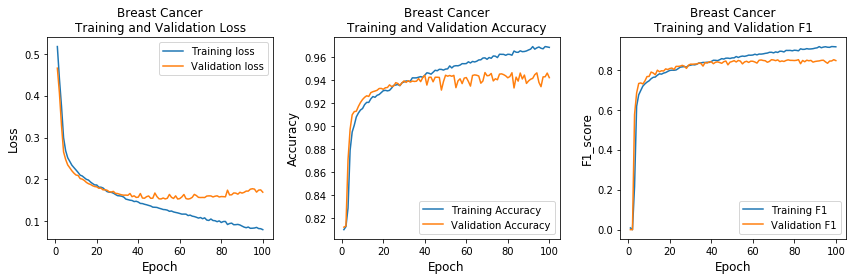

In [97]:
## Models were trained in HPC and output scores are uploaded here.
## Doctor_recommendation_RNN4_all_epoch100_lr5_gpu.py
epoch_df=pd.read_csv(os.path.join(base_dir, 'models_2/{}.csv'.format(prefix)))
plot_loss_accuracy_curve(epoch_df,cancer_type)

In [8]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):    
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar(shrink=0.8)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:d} \n({:.2f}%)'.format(cm[i, j], cm[i,j]/cm.sum()*100), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black",fontsize=16)

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()

In [9]:
def plot_acc_bar(cm,title=''):
    acc=[cm[i][i] for i in range(len(classes))]
    acc_freq=acc/cm.sum(axis=1)
    fig = plt.figure(figsize = (3,3))
    ax = fig.add_subplot(1,1,1)
    width = 0.75 # the width of the bars 
    ind = np.arange(len(classes))  # the x locations for the groups
    ax.bar(ind, np.round(acc_freq*100,2), width, edgecolor='black', color = sns.color_palette('hls', len(classes)))
    plt.xticks(ind, labels = classes, fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.ylim(0,110)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Accuracy%', fontsize=12)
    for i, v in enumerate(np.round(acc_freq*100,2)):
        ax.text(i-0.25, v + 1, str(np.round(v,2))+'%', fontsize=12)
    plt.title(title)

In [10]:
def plot_ROC_curve(y_true, y_score,title=''):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_value = auc(fpr, tpr)
    plt.plot(fpr, tpr, color = 'blue', label='ROC curve (area = {:.2f})'.format(auc_value))
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False positive rate',fontsize=12)
    plt.ylabel('True positive rate',fontsize=12)
    plt.title('ROC curve')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.legend(fontsize=16)
    plt.title(title,fontsize=16)
    plt.show()

In [36]:
def DR_RNN_eval(test_loader, model, criterion, device, classes):
    '''Apply the trained model to testing dataset and summarize the overall test_loss/test_acc
    also output testing accuracy for each category and the prediction result for each sample as well as the probability'''
    # Initiate loss and accuracy values
    test_loss = 0.0
    test_acc = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
  
    dt = np.dtype(int)
    true_label = np.array([], dtype = dt)
    pred_label = np.array([], dtype = dt)
    prob_array = np.array([])
    probs_array = np.arange(1,len(classes)+1).reshape(1,-1)
    
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = criterion(output, labels)
            test_loss += loss.item()*inputs.shape[0]
        
            softmax = nn.Softmax(dim=1)
            output_softmax = softmax(output)
            top_probs, preds = output_softmax.topk(1,dim=1)
            equals = preds == labels.view(*preds.shape)
            correct = np.squeeze(equals)
            test_acc += torch.mean(equals.type(torch.FloatTensor)).item()
            for i in range(len(inputs)):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1
    
            if device.type == 'cpu':
                true_label = np.append(true_label, labels)
                pred_label = np.append(pred_label, preds)
                prob_array = np.append(prob_array, top_probs)
                probs_array = np.concatenate((probs_array, output_softmax))
      
            else:
                true_label = np.append(true_label, labels.cpu())
                pred_label = np.append(pred_label, preds.cpu())
                prob_array = np.append(prob_array, top_probs.cpu())
                probs_array = np.concatenate((probs_array, output_softmax.cpu()))
            
      
    test_loss = test_loss/len(test_loader.sampler)
    test_acc = test_acc/len(test_loader)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('Test Accuracy (Overall): {:.3f}%  ({}/{})\n'.format(np.sum(class_correct)/np.sum(class_total)*100, np.sum(class_correct), np.sum(class_total)))
  
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of {}: {:.3f}% ({}/{})'.format(classes[i], class_correct[i]/class_total[i]*100,class_correct[i], class_total[i]))
        else:
            print('Test Accuracy of {}: N/A'.format(classes[i]))
    summary_df = pd.DataFrame({'category': classes, 'correct': class_correct, 'total': class_total})
    pred_df = pd.DataFrame({'true_label': true_label, 'prediction': pred_label, 'prob': prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = ['class_{}'.format(i) for i in range(2)])
    pred_df = pd.merge(pred_df, probs_df, left_index=True, right_index=True)
    return summary_df, pred_df

In [102]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## Load trained model
vocab_size = len(tokenizer.word_index)+1
output_size = 2
embedding_dim = 600
hidden_dim = 128
n_layers = 1
model = DR_RNN(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

if device.type == 'cpu':
    state_dict = torch.load(os.path.join(base_dir, 'models_2/{}.pth'.format(prefix)), map_location='cpu')
else:
    state_dict = torch.load(os.path.join(base_dir,'models_2/{}.pth'.format(prefix)))
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

device: cpu


In [106]:
criterion = nn.CrossEntropyLoss()
classes = np.array(['Class_'+str(i) for i in np.arange(2)])
summary_df, pred_df = DM_RNN_eval(val_loader, model, criterion, device, classes)

Test Loss: 0.174846

Test Accuracy (Overall): 94.633%  (7846.0/8291.0)

Test Accuracy of Class_0: 97.670% (6582.0/6739.0)
Test Accuracy of Class_1: 81.443% (1264.0/1552.0)


In [107]:
summary_df.head()

,category,correct,total
0,Class_0,6582.0,6739.0
1,Class_1,1264.0,1552.0


In [108]:
pred_df.head()

,true_label,prediction,prob,class_0,class_1
0,1,1,0.999513,0.000487,0.999513
1,0,0,0.999856,0.999856,0.000145
2,0,0,0.999981,0.999981,0.000019
3,0,0,0.744403,0.744403,0.255597
4,0,0,0.999891,0.999891,0.000109


In [109]:
summary_df.to_csv(os.path.join(base_dir,'models/{}_summary_df.csv'.format(prefix)),index=False)
pred_df.to_csv(os.path.join(base_dir,'models/{}_pred_df.csv'.format(prefix)),index=False)

In [17]:
summary_df=pd.read_csv(os.path.join(base_dir,'models/{}_summary_df.csv'.format(prefix)))
pred_df=pd.read_csv(os.path.join(base_dir,'models/{}_pred_df.csv'.format(prefix)))

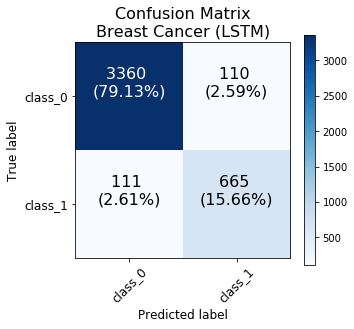

In [27]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
classes = ['class_{}'.format(i) for i in range(2)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nBreast Cancer (LSTM)', cmap=plt.cm.Blues)

In [24]:
pred_df2=pd.read_csv(os.path.join(base_dir, 'models/{}_pred_df_manual.csv'.format(prefix)))

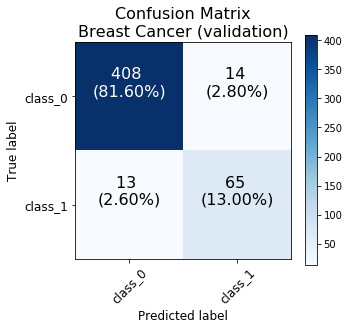

In [26]:
cm = confusion_matrix(pred_df2.true_label, pred_df2.prediction)
classes = ['class_{}'.format(i) for i in range(2)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nBreast Cancer (validation)', cmap=plt.cm.Blues)

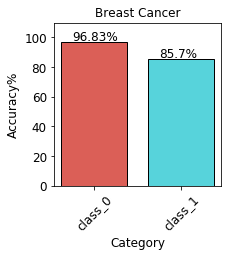

In [14]:
plot_acc_bar(cm,title='Breast Cancer')

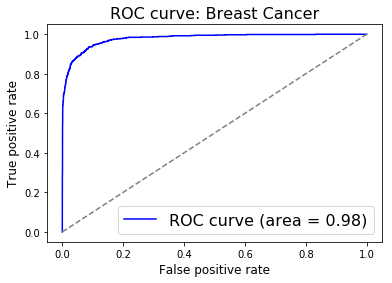

In [15]:
plot_ROC_curve(pred_df.true_label.values, pred_df.class_1.values, title='ROC curve: Breast Cancer')

In [99]:
print('f1 score: {}'.format(f1_score(pred_df.true_label.values, pred_df.prediction)))

f1 score: 0.8575112830431979


### Make prediction

In [110]:
def DR_RNN_pred(test_loader, model, device):
    '''Apply the trained model to testing dataset and summarize the overall test_loss/test_acc
    also output testing accuracy for each category and the prediction result for each sample as well as the probability'''
    # Initiate loss and accuracy values
    
    dt = np.dtype(int)
    pred_label = np.array([], dtype = dt)
    prob_array = np.array([])
    probs_array = np.arange(1,len(classes)+1).reshape(1,-1)
    
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        for inputs in test_loader:
            inputs=inputs[0]
            inputs = inputs.to(device)
            output = model(inputs)
            
            softmax = nn.Softmax(dim=1)
            output_softmax = softmax(output)
            top_probs, preds = output_softmax.topk(1,dim=1)
            
            if device.type == 'cpu':
                pred_label = np.append(pred_label, preds)
                prob_array = np.append(prob_array, top_probs)
                probs_array = np.concatenate((probs_array, output_softmax))
      
            else:
                pred_label = np.append(pred_label, preds.cpu())
                prob_array = np.append(prob_array, top_probs.cpu())
                probs_array = np.concatenate((probs_array, output_softmax.cpu()))
            
    pred_df = pd.DataFrame({'prediction': pred_label, 'prob': prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = ['class_{}'.format(i) for i in range(2)])
    pred_df = pd.merge(pred_df, probs_df, left_index=True, right_index=True)
    return pred_df

In [111]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## Load trained model
vocab_size = len(tokenizer.word_index)+1
output_size = 2
embedding_dim = 600
hidden_dim = 128
n_layers = 1
model = DM_RNN(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

if device.type == 'cpu':
    state_dict = torch.load(os.path.join(base_dir, 'models_2/{}.pth'.format(prefix)), map_location='cpu')
else:
    state_dict = torch.load(os.path.join(base_dir,'models_2/{}.pth'.format(prefix)))
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

device: cpu


In [112]:
pred_df = DR_RNN_pred(test_loader, model, device)

In [114]:
pred_df.index=abstract_test_df.index

In [118]:
pred_df.rename(columns={'prediction':cancer_type},inplace=True)

In [119]:
pred_df.head()

,Breast Cancer,prob,class_0,class_1
pmid,,,,
10037348,0,0.999388,0.999388,0.000612
10873802,0,0.993733,0.993733,0.006267
11050493,0,0.997884,0.997884,0.002116
11096383,0,0.997968,0.997968,0.002031
11734111,0,0.988677,0.988677,0.011323


In [121]:
pred_df.to_csv(os.path.join(base_dir,'models_2/{}_test_df.csv'.format(prefix)),index=True,index_label='pmid')

### Merge prediction files

In [105]:
abstract_test_df['pmid']=abstract_test_df.index

In [114]:
abstract_test_df.shape

(8475, 11)

In [122]:
cancer_types= np.array(cancertype_flattened_df.cancer_type.value_counts().index)[:29]

In [123]:
test_df_list=[abstract_test_df]
for i in cancer_types:
    file_name=cancer_prefix_dict[i]+'_test_df.csv'
    file=pd.read_csv(os.path.join(base_dir+'/models_2', file_name),index_col='pmid').drop(['prob','class_0','class_1'],axis=1)   
    test_df_list.append(file)

In [124]:
len(test_df_list)

30

In [125]:
abstract_test_df2 = pd.concat(test_df_list,axis=1,sort=False)

In [126]:
abstract_test_df2.head()

,article_title,journal_title,journal_abbre,article_date,abstract,article_type,pub_days,citation,abstract_clean,text_clean_seq,...,Gastric Cancer,Gastrointestinal Tumor,Endometrial Cancer,Acute Lymphoblastic Leukemia (ALL),Chronic Lymphocytic Leukemia (CLL),Cardiac Tumors,Cervical Cancer,Esophageal Cancer,Thyroid Cancer,Rectal Cancer
pmid,,,,,,,,,,,,,,,,,,,,,
10037348,In vivo trial comparing patients' tolerance of...,Lasers in surgery and medicine,Lasers Surg Med,1999-01-01,Different types of Q-switched lasers have been...,Clinical Trial,7690.0,59.0,Different types of Q-switched lasers have been...,"[338, 630, 1, 4170, 7883, 23018, 47, 85, 204, ...",...,0,0,0,0,0,0,0,0,0,0
10873802,A human homolog of the C. elegans polarity det...,Current biology : CB,Curr. Biol.,2000-06-01,Rac and Cdc42 are members of the Rho family of...,Journal Article,7173.0,219.0,Rac and Cdc42 are members of the Rho family of...,"[11173, 2, 14297, 32, 1684, 1, 3, 5722, 607, 1...",...,0,0,0,0,0,0,0,0,0,0
11050493,An in vivo trial comparing the clinical effica...,Dermatologic surgery : official publication fo...,Dermatol Surg,2000-10-01,Q-switched 755 nm alexandrite (QS alex) and Q-...,Clinical Trial,7051.0,55.0,Q-switched 755 nm alexandrite QS alex and Q-sw...,"[4170, 7883, 14753, 2878, 42310, 9347, 15176, ...",...,0,0,0,0,0,0,0,0,0,0
11096383,A retrospective analysis of complications in t...,Dermatologic surgery : official publication fo...,Dermatol Surg,2000-11-01,Studies on the use of Q-switched alexandrite (...,Comparative Study,7020.0,65.0,Studies on the use of Q-switched alexandrite Q...,"[94, 23, 3, 119, 1, 4170, 7883, 42310, 9347, 1...",...,0,0,0,0,0,0,0,0,0,0
11734111,Evolving therapies: farnesyltransferase inhibi...,Current oncology reports,Curr Oncol Rep,2002-01-01,Farnesyltransferase inhibitors (FTIs) are comp...,Journal Article,6594.0,34.0,Farnesyltransferase inhibitors FTIs are compou...,"[7480, 222, 8576, 32, 2411, 1114, 6, 6178, 5, ...",...,0,0,0,0,0,0,0,0,0,0


In [127]:
abstract_test_df2.shape

(8475, 40)

In [128]:
abstract_df2_annot=pd.concat([abstract_train_df, abstract_test_df2],sort=False)

In [129]:
abstract_df2_annot.shape

(50930, 41)

In [131]:
pickle.dump(abstract_df2_annot, open(os.path.join(base_dir, "data/abstract_citation_annot_df_50930.pkl"), "wb"))

In [132]:
abstract_df2_annot.to_csv(os.path.join(base_dir, "data/abstract_citation_annot_df_50930.csv"),index=False)

In [223]:
abstract_df=pd.read_csv(os.path.join(base_dir, "data/abstract_citation_annot_df_50930.csv"),index_col='pmid')

In [224]:
abstract_df.shape

(50930, 40)

In [135]:
abstrat_df.columns

Index(['article_title', 'journal_title', 'journal_abbre', 'article_date',
       'abstract', 'article_type', 'pub_days', 'citation', 'abstract_clean',
       'Breast Cancer', 'Lung Cancer', 'Leukemia', 'Prostate Cancer',
       'Colorectal Cancer', 'Lymphoma', 'Bone Cancer', 'Melanoma',
       'Liver Cancer', 'Kidney Cancer', 'Ovarian Cancer', 'Pancreatic Cancer',
       'Brain Tumor', 'Head and Neck Cancer', 'Acute Myeloid Leukemia (AML)',
       'Multiple Myeloma', 'Sarcoma', 'Bladder Cancer', 'Skin Cancer',
       'Gastric Cancer', 'Gastrointestinal Tumor', 'Endometrial Cancer',
       'Acute Lymphoblastic Leukemia (ALL)',
       'Chronic Lymphocytic Leukemia (CLL)', 'Cardiac Tumors',
       'Cervical Cancer', 'Esophageal Cancer', 'Thyroid Cancer',
       'Rectal Cancer', 'text_clean_seq', 'text_length'],
      dtype='object')

In [136]:
abstract_catalog=pd.read_csv(os.path.join(base_dir,'data/abstract_citation_annot_df_50930.csv'),index_col='pmid')

In [137]:
abstract_catalog.shape

(50930, 40)

In [161]:
cancer_types= np.array(cancertype_flattened_df.cancer_type.value_counts().index)[:29]

In [162]:
cancer_counts={}
for cancer_type in cancer_types:
    cancer_counts[cancer_type]=(abstract_catalog[cancer_type]==1).sum()

In [163]:
cancer_counts55_df=cancertype_flattened_df.cancer_type.value_counts().to_frame().rename(columns={'cancer_type':'counts1'})
cancer_counts55_df.index.name='cancer_type'
cancer_counts55_df.head()

,counts1
cancer_type,
Breast Cancer,7757
Lung Cancer,5201
Leukemia,4755
Prostate Cancer,3878
Colorectal Cancer,3412


In [165]:
cancer_counts55_df.to_csv(os.path.join(base_dir,'data/abstract_cancer_counts55_df.csv'),index=True)

In [166]:
cancer_counts55_df=pd.read_csv(os.path.join(base_dir,'data/abstract_cancer_counts55_df.csv'),index_col='cancer_type')

In [167]:
cancer_counts55_df.shape

(55, 1)

In [168]:
cancer_counts29_df=cancer_counts55_df[:29]

In [169]:
cancer_counts_df2=pd.DataFrame.from_dict(cancer_counts,orient='index').rename(columns={0:'counts2'})
cancer_counts_df2.index.name='cancer_type'
cancer_counts_df2.head()

,counts2
cancer_type,
Breast Cancer,8563
Lung Cancer,5518
Leukemia,4962
Prostate Cancer,4018
Colorectal Cancer,3611


In [170]:
cancer_counts29_df2=pd.merge(cancer_counts29_df,cancer_counts_df2,left_index=True,right_index=True)
print(cancer_counts29_df2.shape)
cancer_counts29_df2.head()

(29, 2)


,counts1,counts2
cancer_type,,
Breast Cancer,7757,8563
Lung Cancer,5201,5518
Leukemia,4755,4962
Prostate Cancer,3878,4018
Colorectal Cancer,3412,3611


In [171]:
cancer_counts29_df2.to_csv(os.path.join(base_dir, 'data/abstract_cancer_counts29_df.csv'),index=True)

In [172]:
cancer_counts29_df2=pd.read_csv(os.path.join(base_dir, 'data/abstract_cancer_counts29_df.csv'),index_col='cancer_type')

In [173]:
cancer_counts29_df2.shape

(29, 2)

### Validation statistics

In [176]:
cancer_type='Breast Cancer'
prefix=cancer_prefix_dict[cancer_type]
summary_df = pd.read_csv(os.path.join(base_dir,'models_2/{}_summary_df.csv'.format(prefix)))
pred_df = pd.read_csv(os.path.join(base_dir,'models_2/{}_pred_df.csv'.format(prefix)))

In [177]:
summary_df

,category,correct,total
0,Class_0,6732.0,6940.0
1,Class_1,1326.0,1551.0


In [178]:
pred_df.head()

,true_label,prediction,prob,class_0,class_1
0,0,0,0.999485,0.999485,0.000515
1,0,0,0.999820,0.999820,0.000180
2,0,0,0.993727,0.993727,0.006273
3,0,0,0.999568,0.999568,0.000432
4,0,0,0.999996,0.999996,0.000004


In [182]:
class0_acc = summary_df.correct[0]/summary_df.total[0]
class1_acc = summary_df.correct[1]/summary_df.total[1]
recall = recall_score(pred_df.true_label, pred_df.prediction)
precision = precision_score(pred_df.true_label, pred_df.prediction)
f1 = f1_score(pred_df.true_label, pred_df.prediction)
auc_score = roc_auc_score(pred_df.true_label, pred_df.class_1)

In [188]:
class1_acc

0.8549323017408124

In [84]:
class0_acc_dict = {}
class1_acc_dict = {}
recall_dict = {}
precision_dict = {}
f1_dict = {}
auc_score_dict = {}

In [85]:
def RNN_val_performance(cancer_type):
    prefix=cancer_prefix_dict[cancer_type]
    summary_df = pd.read_csv(os.path.join(base_dir,'models_2/{}_summary_df.csv'.format(prefix)))
    pred_df = pd.read_csv(os.path.join(base_dir,'models_2/{}_pred_df.csv'.format(prefix)))
    class0_acc_dict[cancer_type] = summary_df.correct[0]/summary_df.total[0]
    class1_acc_dict[cancer_type] = summary_df.correct[1]/summary_df.total[1]
    recall_dict[cancer_type] = recall_score(pred_df.true_label, pred_df.prediction)
    precision_dict[cancer_type] = precision_score(pred_df.true_label, pred_df.prediction)
    f1_dict[cancer_type] = f1_score(pred_df.true_label, pred_df.prediction)
    auc_score_dict[cancer_type] = roc_auc_score(pred_df.true_label, pred_df.class_1)

In [86]:
for cancer_type in np.array(cancertype_flattened_df.cancer_type.value_counts().index)[:29]:
    RNN_val_performance(cancer_type)

In [87]:
df1 = pd.DataFrame.from_dict(class0_acc_dict, orient='index', columns=['class0_acc'])
df2 = pd.DataFrame.from_dict(class1_acc_dict, orient='index', columns=['class1_acc'])
df3 = pd.DataFrame.from_dict(recall_dict, orient='index', columns=['recall_score'])
df4 = pd.DataFrame.from_dict(precision_dict, orient='index', columns=['precision_score'])
df5 = pd.DataFrame.from_dict(f1_dict, orient='index', columns=['f1_score'])
df6 = pd.DataFrame.from_dict(auc_score_dict, orient='index', columns=['auc_score'])

In [88]:
dl_summary_df=pd.concat([df1,df2,df3,df4,df5,df6],axis=1,sort=False)

In [89]:
dl_summary_df.head()

,class0_acc,class1_acc,recall_score,precision_score,f1_score,auc_score
Breast Cancer,0.968300,0.856959,0.856959,0.858065,0.857511,0.978546
Lung Cancer,0.984432,0.744231,0.744231,0.869663,0.802073,0.956631
Leukemia,0.997613,0.937960,0.937960,0.980220,0.958624,0.995662
Prostate Cancer,0.993260,0.793814,0.793814,0.922156,0.853186,0.977347
Colorectal Cancer,0.983993,0.683284,0.683284,0.788494,0.732129,0.960221


In [90]:
dl_summary_df.to_csv(os.path.join(base_dir, 'models/dl_dummary_df.csv'),index=True,index_label='cancer_type')

In [91]:
dl_summary_df=pd.read_csv(os.path.join(base_dir, 'models/dl_dummary_df.csv'),index_col='cancer_type')

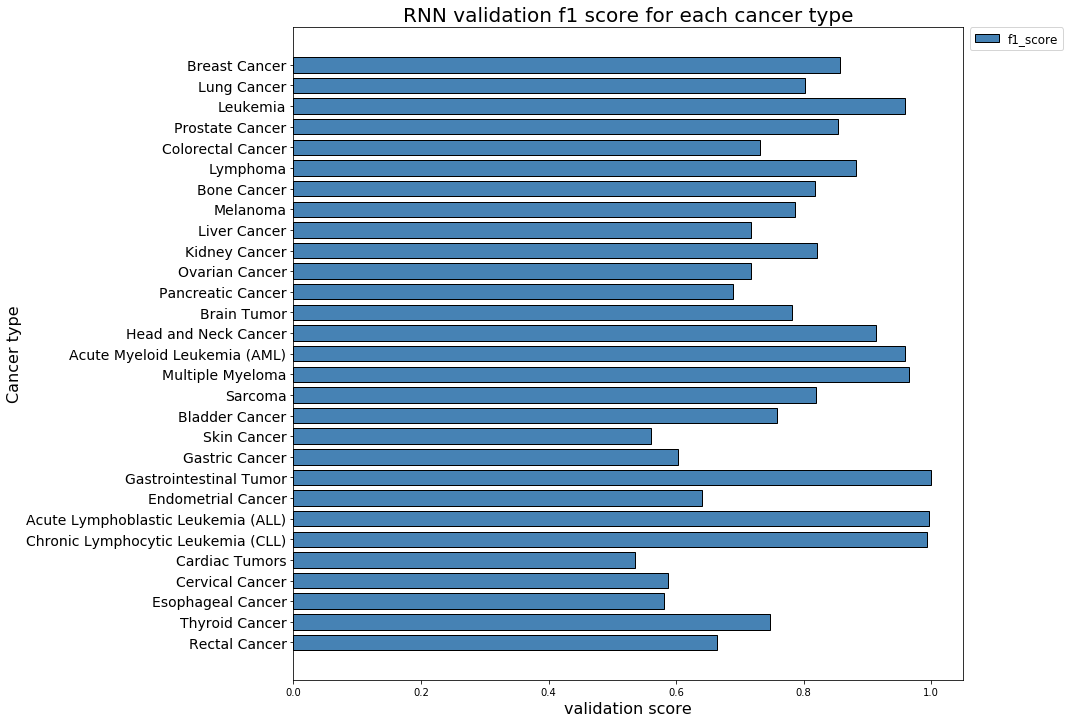

In [92]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1)
width = 0.75 # the width of the bars 
ind = np.arange(len(dl_summary_df))  # the x locations for the groups
ax.barh(ind, dl_summary_df.f1_score, width, edgecolor='black',color='steelblue',label='f1_score')
ax.invert_yaxis()
plt.yticks(ind, labels = dl_summary_df.index, fontsize=12)
plt.yticks(fontsize=14)
#plt.ylim(0,110)
plt.ylabel('Cancer type', fontsize=16)
plt.xlabel('validation score', fontsize=16)
plt.title('RNN validation f1 score for each cancer type', fontsize=20)
plt.legend(fontsize=12,bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)